In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

sklearn version:  0.24.2
TF version:  2.7.0
No GPU was detected. CNNs can be very slow without a GPU.
GPU installed:  True


In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2
import pandas as pd

In [3]:
byclass_train = pd.read_csv("emnist-byclass-train.csv")
byclass_test = pd.read_csv("emnist-byclass-test.csv")
byclass_mapp = pd.read_csv("emnist-byclass-mapping.txt",delimiter = ' ', index_col=0, header=None, squeeze=True)

In [4]:
y1 = np.array(byclass_train.iloc[:,0].values)
x1 = np.array(byclass_train.iloc[:,1:].values)

y2 = np.array(byclass_test.iloc[:,0].values)
x2 = np.array(byclass_test.iloc[:,1:].values)
print(y1.shape)
print(x1.shape)

(697931,)
(697931, 784)


In [5]:
number_of_classes = 62

y1 = tf.keras.utils.to_categorical(y1, number_of_classes)
y2 = tf.keras.utils.to_categorical(y2, number_of_classes)

In [6]:
# Normalise and reshape data
train = x1 / 255.0
test = x2 / 255.0

train_images_number = train.shape[0]
train_images_height = 28
train_images_width = 28
train_images_size = train_images_height*train_images_width

train = train.reshape(train_images_number, train_images_height, train_images_width, 1)

test_images_number = test.shape[0]
test_images_height = 28
test_images_width = 28
test_images_size = test_images_height*test_images_width

test = test.reshape(test_images_number, test_images_height, test_images_width, 1)

In [7]:
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuwxyz'

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train,y1,test_size=0.2,random_state = 42)

## letter로 학습한 모델 이용

In [11]:
letter = keras.models.load_model("letter.h5")

model1 = keras.models.Sequential(letter.layers[:-1])
model1.add(keras.layers.Dropout(0.3))
model1.add(keras.layers.Dense(62, activation="softmax"))

In [12]:
for layer in model1.layers[:-1]:
    layer.trainable = False

model1.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-4),
                     metrics=["accuracy"])

In [13]:
history = model1.fit(X_train, y_train, epochs=4,
                           validation_data=(X_val, y_val))

Epoch 1/4
17449/17449 [==============================] - 93s 5ms/step - loss: 3.6900 - accuracy: 0.2376 - val_loss: 2.2676 - val_accuracy: 0.5021
Epoch 2/4
17449/17449 [==============================] - 92s 5ms/step - loss: 2.3164 - accuracy: 0.4662 - val_loss: 1.6521 - val_accuracy: 0.6316
Epoch 3/4
17449/17449 [==============================] - 90s 5ms/step - loss: 1.8481 - accuracy: 0.5564 - val_loss: 1.3629 - val_accuracy: 0.6823
Epoch 4/4
17449/17449 [==============================] - 92s 5ms/step - loss: 1.5889 - accuracy: 0.6050 - val_loss: 1.1911 - val_accuracy: 0.7090


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

In [17]:
for layer in model1.layers[:-1]:
    layer.trainable = True

model1.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=["accuracy"])
history = model1.fit(X_train, y_train, epochs=16,
                           validation_data=(X_val, y_val), callbacks=[MCP,ES,RLP])

Epoch 1/16
17449/17449 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.7965
Epoch 00001: val_accuracy improved from -inf to 0.84441, saving model to Best_points.h5
17449/17449 [==============================] - 331s 19ms/step - loss: 0.6269 - accuracy: 0.7965 - val_loss: 0.4400 - val_accuracy: 0.8444 - lr: 1.0000e-04
Epoch 2/16
17447/17449 [============================>.] - ETA: 0s - loss: 0.4565 - accuracy: 0.8413
Epoch 00002: val_accuracy improved from 0.84441 to 0.85241, saving model to Best_points.h5
17449/17449 [==============================] - 334s 19ms/step - loss: 0.4565 - accuracy: 0.8413 - val_loss: 0.4108 - val_accuracy: 0.8524 - lr: 1.0000e-04
Epoch 3/16
17447/17449 [============================>.] - ETA: 0s - loss: 0.4167 - accuracy: 0.8521
Epoch 00003: val_accuracy improved from 0.85241 to 0.85704, saving model to Best_points.h5
17449/17449 [==============================] - 345s 20ms/step - loss: 0.4167 - accuracy: 0.8521 - val_loss: 0.3980 - val

## digit로 학습한 모델 이용

In [21]:
mnist = keras.models.load_model("mnist.h5")
model2 = keras.models.Sequential(mnist.layers[:-1])
model2.add(keras.layers.Dense(62, activation="softmax"))

In [22]:
for layer in model2.layers[:-1]:
    layer.trainable = False

model2.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-4),
                     metrics=["accuracy"])

In [24]:
history = model2.fit(X_train, y_train, epochs=4,
                           validation_data=(X_val, y_val))

Epoch 1/4
17449/17449 [==============================] - 514s 29ms/step - loss: 2.6637 - accuracy: 0.4302 - val_loss: 1.8376 - val_accuracy: 0.5374
Epoch 2/4
17449/17449 [==============================] - 518s 30ms/step - loss: 2.2172 - accuracy: 0.4787 - val_loss: 1.6390 - val_accuracy: 0.5691
Epoch 3/4
17449/17449 [==============================] - 512s 29ms/step - loss: 2.0037 - accuracy: 0.5021 - val_loss: 1.5227 - val_accuracy: 0.5900
Epoch 4/4
17449/17449 [==============================] - 518s 30ms/step - loss: 1.8671 - accuracy: 0.5213 - val_loss: 1.4397 - val_accuracy: 0.6064


In [27]:
for layer in model2.layers[:-1]:
    layer.trainable = True

model2.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=["accuracy"])
history = model2.fit(X_train, y_train, epochs=16, 
                           validation_data=(X_val, y_val), callbacks=[MCP,ES,RLP])

Epoch 1/16
17449/17449 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.7955
Epoch 00001: val_accuracy did not improve from 0.86181
17449/17449 [==============================] - 2340s 134ms/step - loss: 0.6436 - accuracy: 0.7955 - val_loss: 0.3962 - val_accuracy: 0.8571 - lr: 1.0000e-04
Epoch 2/16
17449/17449 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.8495
Epoch 00002: val_accuracy improved from 0.86181 to 0.86617, saving model to Best_points.h5
17449/17449 [==============================] - 2250s 129ms/step - loss: 0.4338 - accuracy: 0.8495 - val_loss: 0.3686 - val_accuracy: 0.8662 - lr: 1.0000e-04
Epoch 3/16
17449/17449 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.8595
Epoch 00003: val_accuracy improved from 0.86617 to 0.86837, saving model to Best_points.h5
17449/17449 [==============================] - 2299s 132ms/step - loss: 0.3973 - accuracy: 0.8595 - val_loss: 0.3582 - val_accuracy: 0.8684 - lr: 1.0

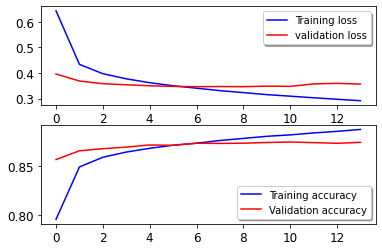

In [28]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [37]:
import itertools

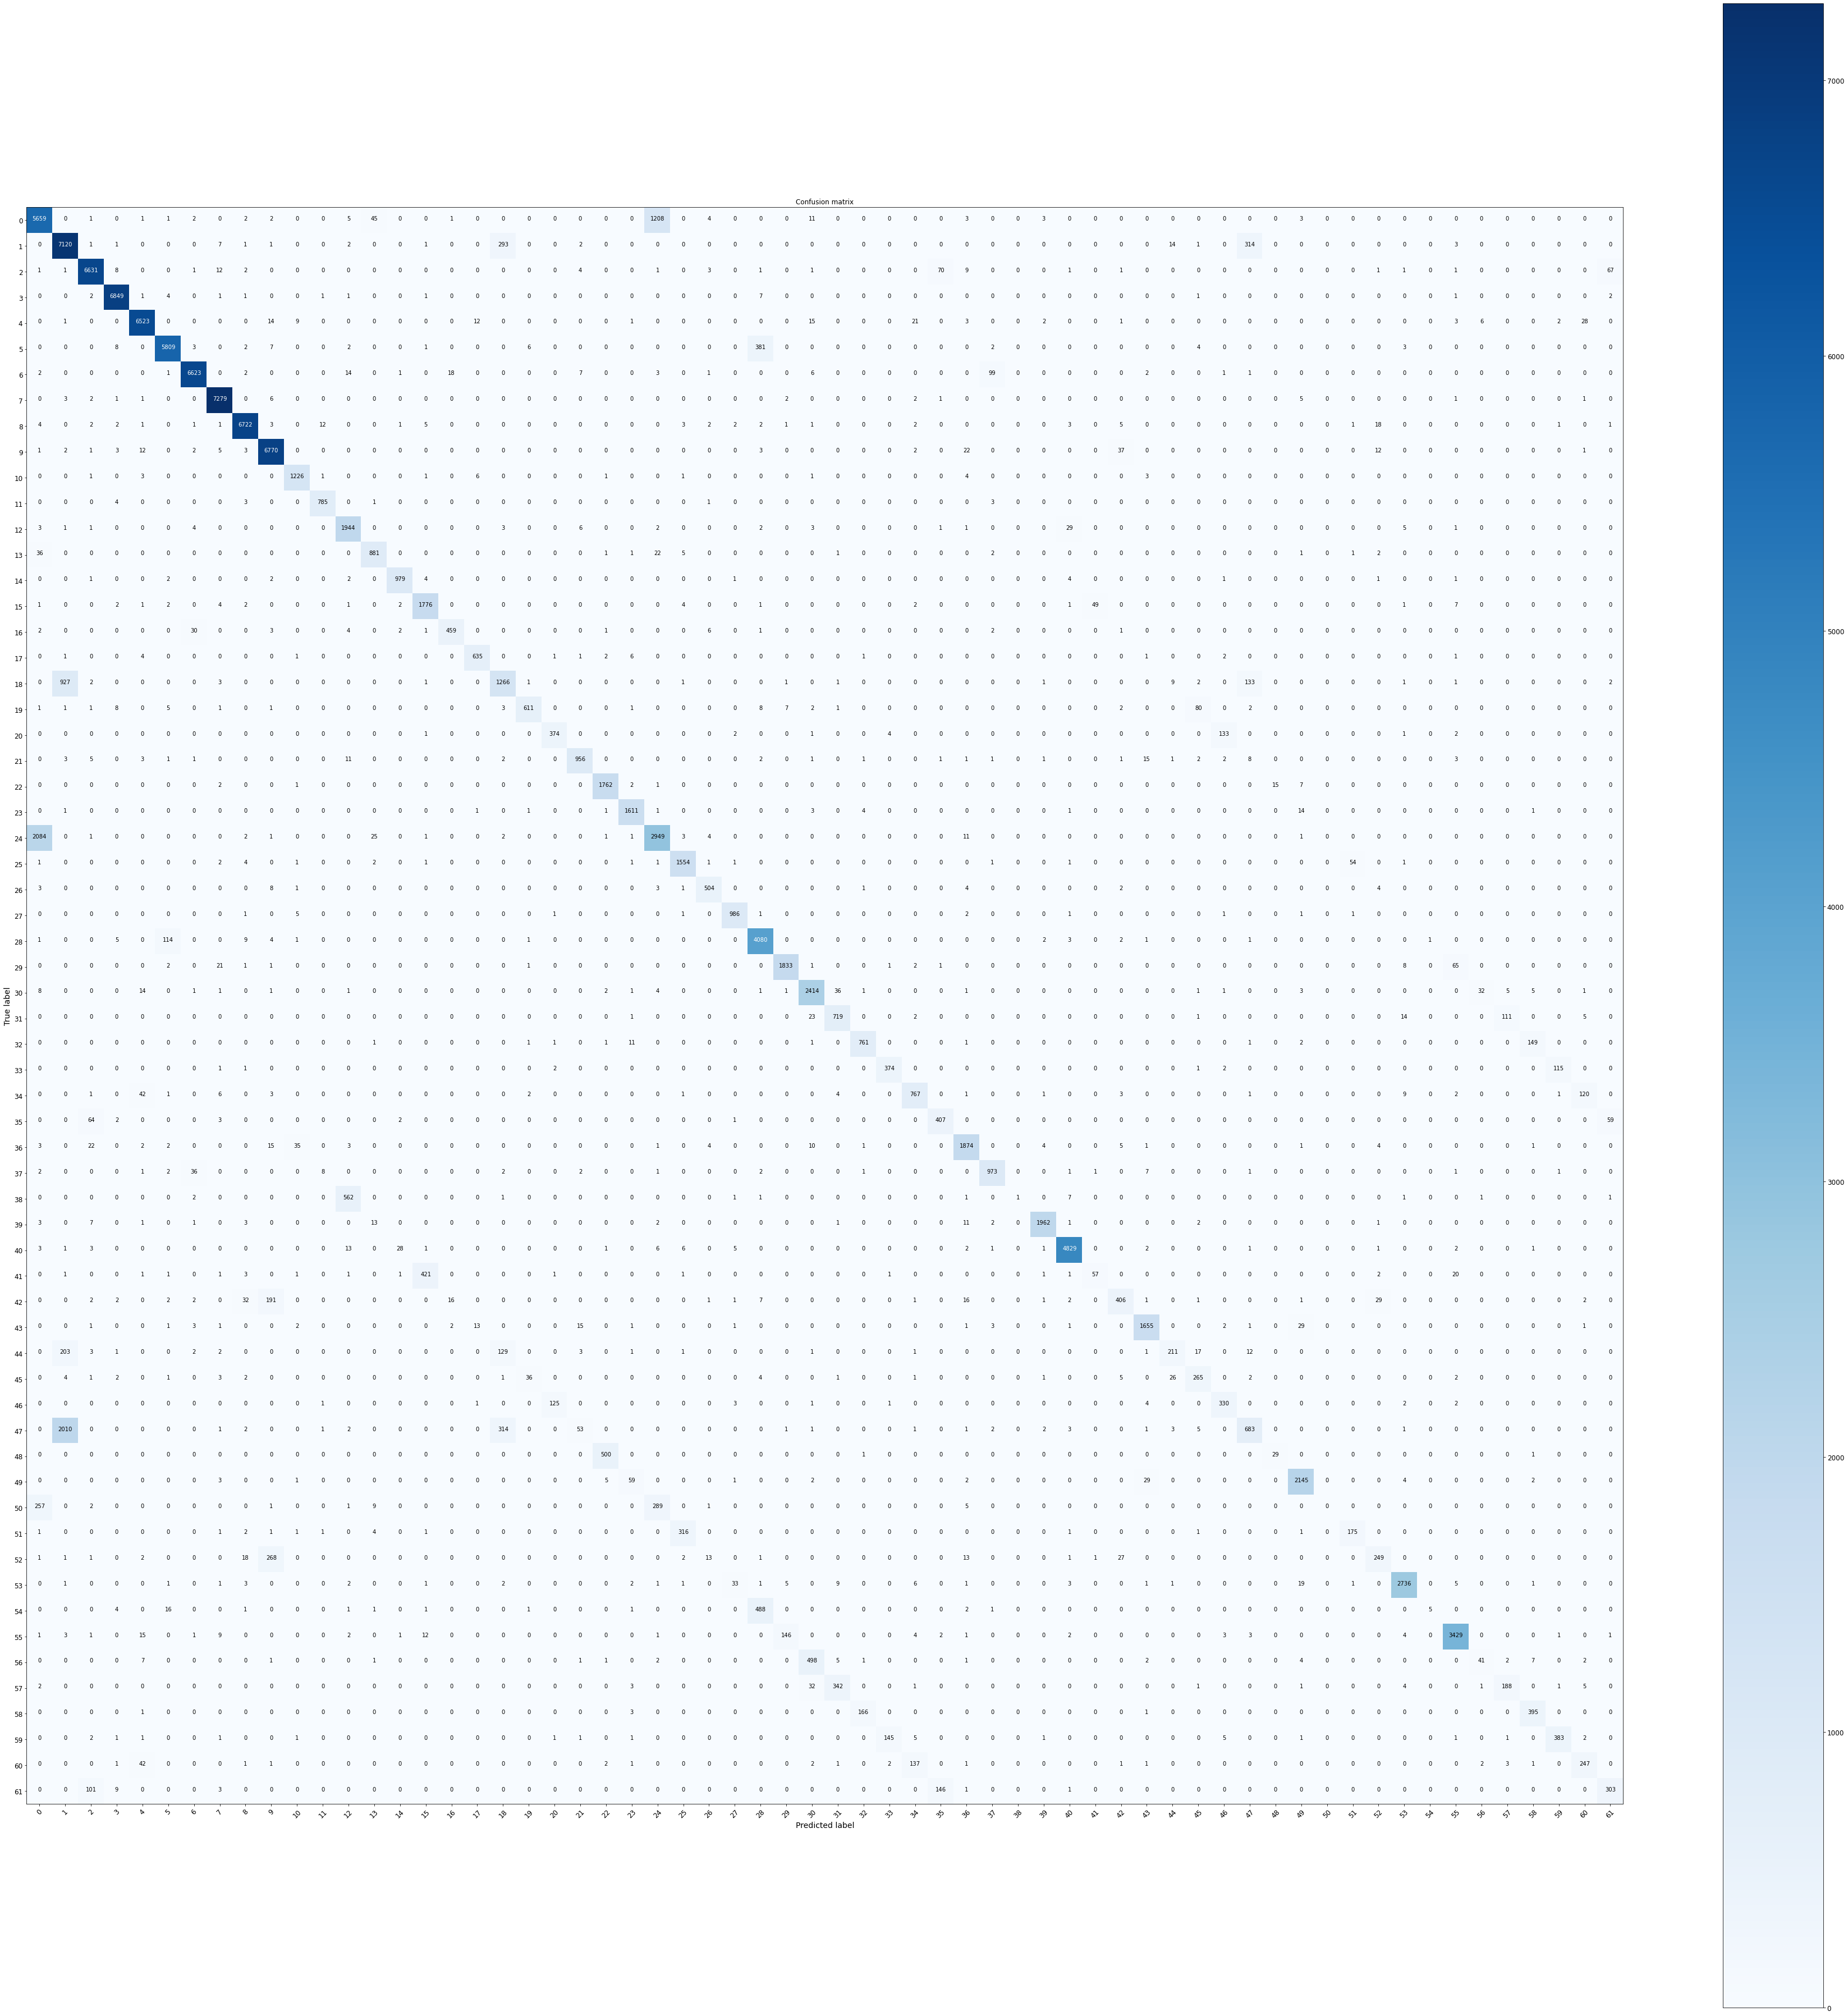

In [38]:
# Look at confusion matrix 
from sklearn.metrics import confusion_matrix

num_classes=62
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams["figure.figsize"] = (50,50)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model2.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(num_classes)) 

In [39]:
score = model2.evaluate(test, y2)

3636/3636 [==============================] - 81s 22ms/step - loss: 0.3413 - accuracy: 0.8762


## class_weight 변경해서 학습해보기

In [40]:
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

C:\Users\asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


35
1     38374
7     35754
3     35143
0     34585
6     34232
      ...  
46     2491
20     2468
51     2448
60     2365
45     1896
Length: 62, dtype: int64

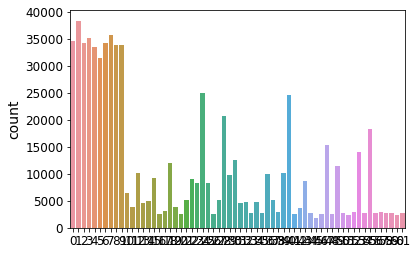

In [46]:
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuwxyz'
labels = byclass_train.reindex(columns=byclass_train.columns[:1])

# Drop 'label' column
data = byclass_train.reindex(columns=byclass_train.columns[1:])

test_labels = byclass_train.reindex(columns=byclass_train.columns[:1])
test_ = byclass_train.reindex(columns=byclass_train.columns[1:])

g = sns.countplot(labels.to_numpy().reshape(-1))

labels.value_counts()

In [62]:
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
labels.value_counts()

35
1     38374
7     35754
3     35143
0     34585
6     34232
2     34203
8     33946
9     33847
4     33535
5     31416
24    24983
40    24631
28    20764
55    18262
47    15318
53    14105
30    12602
18    11946
49    11418
39    10177
12    10094
36    10033
29     9820
15     9182
22     9002
43     8738
25     8347
23     8237
10     6407
37     5159
21     5076
27     5073
14     4934
34     4743
32     4695
31     4637
13     4562
11     3878
19     3762
42     3687
17     3152
52     2994
57     2910
38     2854
56     2830
59     2822
33     2771
50     2749
61     2725
44     2725
35     2700
54     2699
58     2697
48     2645
26     2605
41     2561
16     2517
46     2491
20     2468
51     2448
60     2365
45     1896
dtype: int64

In [70]:
total = 697932
weight0 = (1/34585)*(total/62.0)
weight1 = (1/38374)*(total/62.0)
weight2 = (1/34203)*(total/62.0)
weight3 = (1/34585)*(total/62.0)
weight4 = (1/33535)*(total/62.0)
weight5 = (1/31416)*(total/62.0)
weight6 = (1/34232)*(total/62.0)
weight7 = (1/35754)*(total/62.0)
weight8 = (1/33946)*(total/62.0)
weight9 = (1/33847)*(total/62.0)
weight10 = (1/6407)*(total/62.0)
weight11 = (1/3878)*(total/62.0)
weight12 = (1/10094)*(total/62.0)
weight13 = (1/4562)*(total/62.0)
weight14 = (1/4934)*(total/62.0)
weight15 = (1/9182)*(total/62.0)
weight16 = (1/2517)*(total/62.0)
weight17 = (1/3152)*(total/62.0)
weight18 = (1/11946)*(total/62.0)
weight19 = (1/3762)*(total/62.0)
weight20 = (1/2468)*(total/62.0)
weight21 = (1/5076)*(total/62.0)
weight22 = (1/9002)*(total/62.0)
weight23 = (1/8237)*(total/62.0)
weight24 = (1/24983)*(total/62.0)
weight25 = (1/8347)*(total/62.0)
weight26 = (1/2605)*(total/62.0)
weight27 = (1/5073)*(total/62.0)
weight28 = (1/20764)*(total/62.0)
weight29 = (1/9820)*(total/62.0)
weight30 = (1/12602)*(total/62.0)
weight31 = (1/4637)*(total/62.0)
weight32 = (1/4695)*(total/62.0)
weight33 = (1/2771)*(total/62.0)
weight34 = (1/4743)*(total/62.0)
weight35 = (1/2700)*(total/62.0)
weight36 = (1/10033)*(total/62.0)
weight37 = (1/5159)*(total/62.0)
weight38 = (1/2854)*(total/62.0)
weight39 = (1/10177)*(total/62.0)
weight40 = (1/24631)*(total/62.0)
weight41 = (1/2561)*(total/62.0)
weight42 = (1/3687)*(total/62.0)
weight43 = (1/8738)*(total/62.0)
weight44 = (1/2725)*(total/62.0)
weight45 = (1/1896)*(total/62.0)
weight46 = (1/2491)*(total/62.0)
weight47 = (1/15318)*(total/62.0)
weight48 = (1/2645)*(total/62.0)
weight49 = (1/11418)*(total/62.0)
weight50 = (1/2749)*(total/62.0)
weight51 = (1/2448)*(total/62.0)
weight52 = (1/2994)*(total/62.0)
weight53 = (1/14105)*(total/62.0)
weight54 = (1/2699)*(total/62.0)
weight55 = (1/18262)*(total/62.0)
weight56 = (1/2830)*(total/62.0)
weight57 = (1/2910)*(total/62.0)
weight58 = (1/2697)*(total/62.0)
weight59 = (1/2822)*(total/62.0)
weight60 = (1/2365)*(total/62.0)
weight61 = (1/2725)*(total/62.0)

class_weight = {0:weight0, 1: weight1, 2:weight2, 3:weight3, 4:weight4, 5:weight5, 6:weight6, 7:weight7, 8:weight8, 9:weight9, 10:weight10,
               11:weight11, 12:weight12, 13:weight13, 14:weight14, 15:weight15, 16:weight16, 17:weight17, 18:weight18, 19:weight19, 20:weight20,
               21:weight21, 22:weight22, 23:weight23, 24:weight24, 25:weight25, 26:weight26, 27:weight27, 28:weight28, 29:weight29, 30:weight30,
               31:weight31, 32:weight32, 33:weight33, 34:weight34, 35:weight35, 36:weight36, 37:weight37, 38:weight38, 39:weight39, 40:weight40,
               41:weight41, 42:weight42, 43:weight43, 44:weight44, 45:weight45, 46:weight46, 47:weight47, 48:weight48, 49:weight49, 50:weight50,
               51:weight51, 52:weight52, 53:weight53, 54:weight54, 55:weight55, 56:weight56, 57:weight57, 58:weight58, 59:weight59, 60:weight60,
               61:weight61}

In [76]:
weighted_history = model2.fit(X_train, y_train, epochs=15, 
                           validation_data=(X_val, y_val), callbacks=[MCP,ES,RLP], class_weight=class_weight)

Epoch 1/15
17449/17449 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.8405
Epoch 00001: val_accuracy did not improve from 0.87522
17449/17449 [==============================] - 2341s 134ms/step - loss: 0.4467 - accuracy: 0.8405 - val_loss: 0.4261 - val_accuracy: 0.8326 - lr: 1.0000e-04
Epoch 2/15
17449/17449 [==============================] - ETA: 0s - loss: 0.4311 - accuracy: 0.8389
Epoch 00002: val_accuracy did not improve from 0.87522
17449/17449 [==============================] - 2330s 134ms/step - loss: 0.4311 - accuracy: 0.8389 - val_loss: 0.4378 - val_accuracy: 0.8248 - lr: 1.0000e-04
Epoch 3/15
17449/17449 [==============================] - ETA: 0s - loss: 0.4217 - accuracy: 0.8379
Epoch 00003: val_accuracy did not improve from 0.87522
17449/17449 [==============================] - 2288s 131ms/step - loss: 0.4217 - accuracy: 0.8379 - val_loss: 0.4418 - val_accuracy: 0.8283 - lr: 1.0000e-04
Epoch 4/15
17449/17449 [==============================] - ETA: 0

In [80]:
weighted_history1 =model1.fit(X_train, y_train, epochs=15, batch_size=256, 
                           validation_data=(X_val, y_val), callbacks=[MCP,ES,RLP], class_weight=class_weight)

Epoch 1/15
2181/2182 [============================>.] - ETA: 0s - loss: 0.4225 - accuracy: 0.8334
Epoch 00001: val_accuracy did not improve from 0.87522
2182/2182 [==============================] - 124s 57ms/step - loss: 0.4225 - accuracy: 0.8334 - val_loss: 0.4725 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 2/15
2181/2182 [============================>.] - ETA: 0s - loss: 0.4124 - accuracy: 0.8348
Epoch 00002: val_accuracy did not improve from 0.87522
2182/2182 [==============================] - 122s 56ms/step - loss: 0.4124 - accuracy: 0.8348 - val_loss: 0.4812 - val_accuracy: 0.8113 - lr: 1.0000e-04
Epoch 3/15
2181/2182 [============================>.] - ETA: 0s - loss: 0.4044 - accuracy: 0.8366
Epoch 00003: val_accuracy did not improve from 0.87522
2182/2182 [==============================] - 123s 56ms/step - loss: 0.4044 - accuracy: 0.8366 - val_loss: 0.4772 - val_accuracy: 0.8179 - lr: 1.0000e-04
Epoch 4/15
2181/2182 [============================>.] - ETA: 0s - loss: 0.3978 - a

In [79]:
best_model = keras.models.load_model("Best_points.h5")
score = best_model.evaluate(test, y2)

3636/3636 [==============================] - 82s 23ms/step - loss: 0.3413 - accuracy: 0.8762


In [81]:
model3 = mnist = keras.models.load_model("mnist.h5")
model3 = keras.models.Sequential(mnist.layers[:-1])
model3.add(keras.layers.Dense(128, activation='relu'))
model3.add(keras.layers.Dropout(0.3))
model3.add(keras.layers.Dense(62, activation="softmax"))

In [82]:
for layer in model3.layers[:-3]:
    layer.trainable = False

model3.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-4),
                     metrics=["accuracy"])

In [83]:
history3 = model3.fit(X_train, y_train, epochs=4, batch_size=256,
                           validation_data=(X_val, y_val))

Epoch 1/4
2182/2182 [==============================] - 391s 179ms/step - loss: 5.1277 - accuracy: 0.0566 - val_loss: 2.7098 - val_accuracy: 0.4610
Epoch 2/4
2182/2182 [==============================] - 395s 181ms/step - loss: 3.5293 - accuracy: 0.2316 - val_loss: 2.3102 - val_accuracy: 0.4909
Epoch 3/4
2182/2182 [==============================] - 397s 182ms/step - loss: 3.0657 - accuracy: 0.3352 - val_loss: 2.1969 - val_accuracy: 0.4918
Epoch 4/4
2182/2182 [==============================] - 392s 180ms/step - loss: 2.8565 - accuracy: 0.3796 - val_loss: 2.1311 - val_accuracy: 0.4930


In [84]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                  

In [88]:
for layer in model3.layers[:-1]:
    layer.trainable = True

model3.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=["accuracy"])
history3 = model3.fit(X_train, y_train, epochs=15,
                           validation_data=(X_val, y_val), callbacks=[MCP,ES,RLP])

Epoch 1/15
17449/17449 [==============================] - ETA: 0s - loss: 0.8214 - accuracy: 0.7522
Epoch 00001: val_accuracy did not improve from 0.87522
17449/17449 [==============================] - 2283s 131ms/step - loss: 0.8214 - accuracy: 0.7522 - val_loss: 0.4266 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 2/15
17449/17449 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.8377
Epoch 00002: val_accuracy did not improve from 0.87522
17449/17449 [==============================] - 2316s 133ms/step - loss: 0.4858 - accuracy: 0.8377 - val_loss: 0.3929 - val_accuracy: 0.8603 - lr: 1.0000e-04
Epoch 3/15
17449/17449 [==============================] - ETA: 0s - loss: 0.4352 - accuracy: 0.8512
Epoch 00003: val_accuracy did not improve from 0.87522
17449/17449 [==============================] - 2293s 131ms/step - loss: 0.4352 - accuracy: 0.8512 - val_loss: 0.3782 - val_accuracy: 0.8646 - lr: 1.0000e-04
Epoch 4/15
17449/17449 [==============================] - ETA: 0

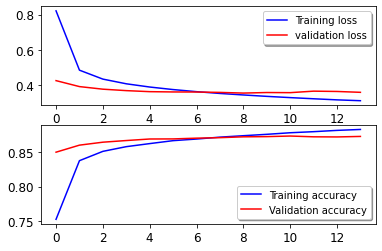

In [89]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history3.history['loss'], color='b', label="Training loss")
ax[0].plot(history3.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history3.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history3.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [90]:
history3 = model3.fit(X_train, y_train, epochs=15,
                           validation_data=(X_val, y_val), callbacks=[MCP,ES,RLP], class_weight=class_weight)

Epoch 1/15
17449/17449 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.8364
Epoch 00001: val_accuracy did not improve from 0.87522
17449/17449 [==============================] - 2286s 131ms/step - loss: 0.4882 - accuracy: 0.8364 - val_loss: 0.4403 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 2/15
17449/17449 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.8337
Epoch 00002: val_accuracy did not improve from 0.87522
17449/17449 [==============================] - 2280s 131ms/step - loss: 0.4696 - accuracy: 0.8337 - val_loss: 0.4529 - val_accuracy: 0.8257 - lr: 1.0000e-04
Epoch 3/15
17449/17449 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8311
Epoch 00003: val_accuracy did not improve from 0.87522
17449/17449 [==============================] - 2332s 134ms/step - loss: 0.4612 - accuracy: 0.8311 - val_loss: 0.4440 - val_accuracy: 0.8421 - lr: 1.0000e-04
Epoch 4/15
17449/17449 [==============================] - ETA: 0